# **ROAD SEGMENTATION FROM SATELLITE IMAGES USING U-NET**

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.utils import plot_model

In [2]:
maindir = "../input/deepglobe-road-extraction-dataset"
metadata = pd.read_csv('../input/deepglobe-road-extraction-dataset/metadata.csv')
metadata

In [ ]:
metadata['sat_image_path'] = metadata['sat_image_path'].apply(lambda satpath: os.path.join(maindir, satpath))
metadata['mask_path'] = metadata['mask_path'].apply(lambda maskpath: os.path.join(maindir, str(maskpath)))

dataset = metadata[metadata['split'] == 'train']
dataset = dataset.reset_index(drop = True)
dataset.drop('split', inplace = True, axis = 1)
dataset = dataset.sample(frac = 1).reset_index(drop = True)
dataset = dataset[:3500]

In [ ]:
## Function to Load the Images
def loadData(df):
    dataframeObj = [[],[]]
    
    for sat_img, mask_img in zip(df.sat_image_path, df.mask_path):
        Reading_Sat = Image.open(sat_img).convert('L').resize((128, 128))
        Reading_Sat = np.asarray(Reading_Sat)
        Reading_Sat = Reading_Sat/255.
        
        Reading_Mask = Image.open(mask_img).resize((128, 128))
        Reading_Mask = np.asarray(Reading_Mask)[:, :, 0]
        Reading_Mask = Reading_Mask/255.
        
        dataframeObj[0].append(Reading_Sat)
        dataframeObj[1].append(Reading_Mask)
    return np.array(dataframeObj)

In [ ]:
df = loadData(dataset)
df = df.reshape(2, -1, 128, 128, 1)
print(f'{len(df[0])} Images & {len(df[1])} Masks')

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(2,2,1)
plt.imshow(df[0][912], cmap=plt.get_cmap('gray'))
plt.title('Satellite Image')
plt.subplot(2,2,2)
plt.imshow(df[1][912], cmap=plt.get_cmap('gray'))
plt.title('Masked Roads')
plt.subplot(2,2,3)
plt.imshow(df[0][1209], cmap=plt.get_cmap('gray'))
plt.title('Satellite Image')
plt.subplot(2,2,4)
plt.imshow(df[1][1209], cmap=plt.get_cmap('gray'))
plt.title('Masked Roads')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.25, random_state=42)
print(f"Training Set: {len(X_train)} images & {len(y_train)} masks")
print(f"Testing Set: {len(X_test)} images & {len(y_test)} masks")

### **Defining the Model (U-Net) & Creating an Instance**

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, Dropout, concatenate, Activation, Input

def conv2dBlock(inputLayer, numFilters, init, kernelSize=3, actv='selu',doBatchNorm=True):
    x = Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize), activation = actv,
               kernel_initializer = init, padding = 'same')(inputLayer)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize), activation = actv,
               kernel_initializer = init, padding = 'same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    return x

def createUNetModel(inputImg, numFilters=16, drop_rate=0.3, lrn_rate=0.00085, init='lecun_normal'):
    c1 = conv2dBlock(inputImg, numFilters*1, init)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(drop_rate)(p1)
    
    c2 = conv2dBlock(p1, numFilters*2, init)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(drop_rate)(p2)
    
    c3 = conv2dBlock(p2, numFilters*4, init)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(drop_rate)(p3)
    
    c4 = conv2dBlock(p3, numFilters*8, init)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(drop_rate)(p4)
    
    c5 = conv2dBlock(p4, numFilters*16, init)
    
    t6 = Conv2DTranspose(numFilters*8, (3,3), strides = (2,2), padding = 'same')(c5)
    p6 = concatenate([t6, c4])
    p6 = Dropout(drop_rate)(p6)
    c6 = conv2dBlock(p6, numFilters*8, init)
    
    t7 = Conv2DTranspose(numFilters*4, (3,3), strides = (2,2), padding = 'same')(c6)
    p7 = concatenate([t7, c3])
    p7 = Dropout(drop_rate)(p7)
    c7 = conv2dBlock(p7, numFilters*4, init)
    
    t8 = Conv2DTranspose(numFilters*2, (3,3), strides = (2,2), padding = 'same')(c7)
    p8 = concatenate([t8, c2])
    p8 = Dropout(drop_rate)(p8)
    c8 = conv2dBlock(p8, numFilters*2, init)
    
    t9 = Conv2DTranspose(numFilters*1, (3,3), strides = (2,2), padding = 'same')(c8)
    p9 = concatenate([t9, c1])
    p9 = Dropout(drop_rate)(p9)
    c9 = conv2dBlock(p9, numFilters*1, init)
    
    output = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = init)(c9)
    model = tf.keras.Model(inputs = inputImg, outputs = output, name="UNetModel")
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lrn_rate), 
                  loss = tf.keras.losses.BinaryCrossentropy(), 
                  metrics = ['accuracy'])
    return model

In [ ]:
# Instantiating model
uNetModel = createUNetModel(Input((128, 128, 1)))
plot_model(uNyuhetModel, show_shapes=True, show_layer_names=True)

### **Training the Model**

In [10]:
modelResult = uNetModel.fit(x = np.array(X_train),
                            y = np.array(y_train),
                            epochs = 150,
                            validation_split = 0.2)

2022-11-01 15:55:42.577499: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-11-01 15:55:46.508112: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


66/66 [==============================] - 22s 133ms/step - loss: 0.6509 - accuracy: 0.6738 - val_loss: 0.7261 - val_accuracy: 0.4725
Epoch 2/150
66/66 [==============================] - 6s 96ms/step - loss: 0.5169 - accuracy: 0.8941 - val_loss: 0.4606 - val_accuracy: 0.8922
Epoch 3/150
66/66 [==============================] - 7s 100ms/step - loss: 0.3801 - accuracy: 0.9225 - val_loss: 0.3116 - val_accuracy: 0.9158
Epoch 4/150
66/66 [==============================] - 6s 97ms/step - loss: 0.2726 - accuracy: 0.9231 - val_loss: 0.2151 - val_accuracy: 0.9188
Epoch 5/150
66/66 [==============================] - 7s 100ms/step - loss: 0.2073 - accuracy: 0.9229 - val_loss: 0.1801 - val_accuracy: 0.9177
Epoch 6/150
66/66 [==============================] - 6s 97ms/step - loss: 0.1722 - accuracy: 0.9229 - val_loss: 0.1687 - val_accuracy: 0.9148
Epoch 7/150
66/66 [==============================] - 6s 97ms/step - loss: 0.1531 - accuracy: 0.9229 - val_loss: 0.1484 - val_accuracy: 0.9185
Epoch 8/150
66

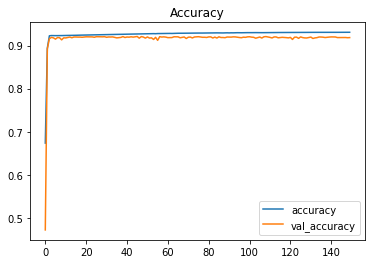

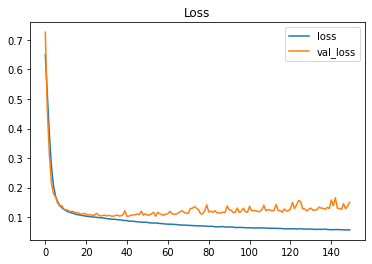

In [11]:
pd.DataFrame(modelResult.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(modelResult.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

### **Model Predictions**

In [12]:
y_pred = uNetModel.predict(np.array(X_test))

In [13]:
def plotResults(image, prediction, target):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    print(f"IoU Score:- {iou_score}")
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1,3,1)
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.title('Image')
    
    plt.subplot(1,3,2)
    plt.imshow(prediction, cmap=plt.get_cmap('gray'))
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(target, cmap=plt.get_cmap('gray'))
    plt.title('Actual Mask')

IoU Score:- 0.0277099609375


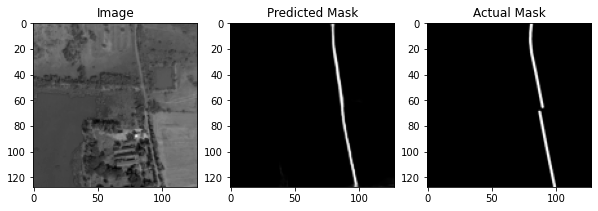

In [14]:
plotResults(X_test[9], y_pred[9], y_test[9])

IoU Score:- 0.1072998046875


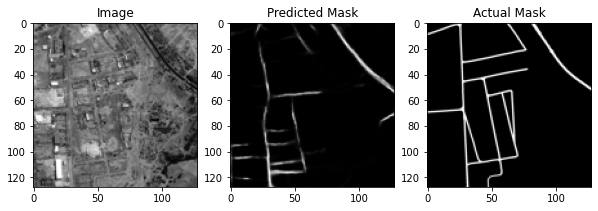

In [15]:
plotResults(X_test[12], y_pred[12], y_test[12])

IoU Score:- 0.0582275390625


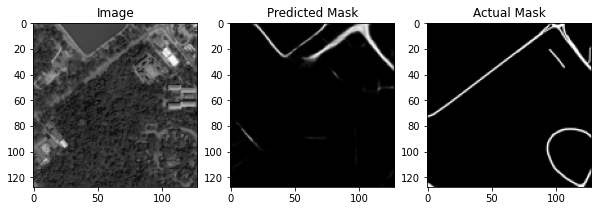

In [16]:
plotResults(X_test[18], y_pred[18], y_test[18])